# Check the whitened data

In [64]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import h5py
import scipy.signal

matplotlib.rcParams['agg.path.chunksize'] = 10000 # Otherwise Overflow plotting too many points
font = {'family' : 'normal',         # dictionary to set font on all matplotlib plots of notebook
        'weight': 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

enable_interactive = True       # Set to false if you don't want interactive plots
if enable_interactive==True:
    %matplotlib notebook

The whitening process carried out by WDF builds a model of the stationary noise PSD in order to suppress the noise component by applying weighting factors to the data. To speed-up this step, the data is divided in $N$ smaller chunks which are fed to separate CPUs for parallel processing. The output of WDF will be in the $outdir$ directory indicated in the JSON configuration file, separated in $N$ subfolders, one for each chunk of data. Let us visualize this (change path accordingly):

In [6]:
folder = '/users/iess/WDF_vs_cWB/data_anushka/'

In [10]:
ls $folder     # with $ you can use the string variable for basic bash commands in Jupyter notebooks

cbc_uniformedSNR_anushka.h5
splitted_segment_cbc_uniformedSNR_anushka/
wp_segment_cbc_uniformedSNR_anushka/


We see the original data file `cbc_uniformedSNR_anushka.h5` and two folders. `wp_segment_cbc_uniformedSNR_anushka` contains the whitening parameters

In [18]:
ls /users/iess/WDF_vs_cWB/data_anushka/wp_segment_cbc_uniformedSNR_anushka

ARcoeff-AR400-fs4096-strain.txt  LVcoeff-AR400-fs4096-strain.txt


while `splitted_segment_cbc_uniformedSNR_anushka/` contains all the chunk subfolders:

In [19]:
ls /users/iess/WDF_vs_cWB/data_anushka/splitted_segment_cbc_uniformedSNR_anushka/

part_0/   part_18/  part_27/  part_36/  part_45/  part_54/  part_63/  part_72/
part_1/   part_19/  part_28/  part_37/  part_46/  part_55/  part_64/  part_73/
part_10/  part_2/   part_29/  part_38/  part_47/  part_56/  part_65/  part_74/
part_11/  part_20/  part_3/   part_39/  part_48/  part_57/  part_66/  part_8/
part_12/  part_21/  part_30/  part_4/   part_49/  part_58/  part_67/  part_9/
part_13/  part_22/  part_31/  part_40/  part_5/   part_59/  part_68/
part_14/  part_23/  part_32/  part_41/  part_50/  part_6/   part_69/
part_15/  part_24/  part_33/  part_42/  part_51/  part_60/  part_7/
part_16/  part_25/  part_34/  part_43/  part_52/  part_61/  part_70/
part_17/  part_26/  part_35/  part_44/  part_53/  part_62/  part_71/


A chunk subfolder has the following structure, with 
  1. The original chunk, 
  2. The whitened chunk
  3. The whitening parameters (and .csv trigger file if the wavelet decomposition was run)

In [22]:
ls /users/iess/WDF_vs_cWB/data_anushka/splitted_segment_cbc_uniformedSNR_anushka/part_0/

cbc_uniformedSNR_anushka.h5  cbc_uniformedSNR_anushka_white.h5  wp/


Let us check the whitened data:

In [79]:
path_string_1 = 'splitted_segment_cbc_uniformedSNR_anushka/part_'
path_string_2 = '/cbc_uniformedSNR_anushka_white.h5'
part_i = 10

with h5py.File(folder+path_string_1+str(part_i)+path_string_2, 'r') as f:
    print(f.keys())
    h_w = np.array(f['strain_white']).astype(float)      # important to choose float

<KeysViewHDF5 ['strain_white']>


<IPython.core.display.Javascript object>


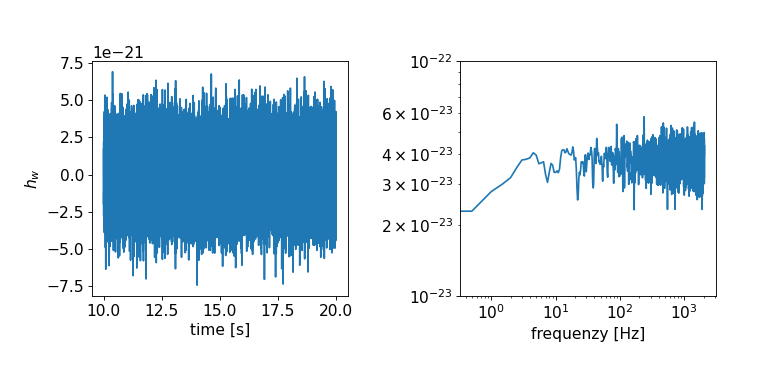

In [87]:
fs= 4096
t = np.arange(0,len(h_w))/fs      # for the time being, we generate manually the times of h_w

t_s, t_e = 10*fs, 20*fs                 # we choose start and end time (in seconds) for plotting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))      # we define the subplot environment

# PLOT TIMESERIES
ax1.plot(t[t_s:t_e], h_w[t_s:t_e])
ax1.set_xlabel('time [s]')
ax1.set_ylabel(r'$h_w$')

# PLOT IN FREQUENCY DOMAIN THE AMPLITUDE SPECTRAL DENSITY
freq, psd = scipy.signal.welch(h_w[t_s: t_e], fs=fs,
                               window='hamming', nperseg=fs, 
                               noverlap=fs//2, nfft=2*fs)   # compute the power spectral density with scipy
asd = np.sqrt(psd)              # the ASD is just the square root of the PSD
ax2.loglog(freq, asd)           # LIGO/Virgo ASDs are generally plotted in a log log scale
ax2.set_ylim(1e-23,1e-22)       # sets the limit of the axis in the plot
ax2.set_xlabel('frequenzy [Hz]')

fig.tight_layout(pad=4);        # padding to avoid overlap between figures


Similarly to what we did with the original data, we can plot the whitened data spectrogram. We observe that the very noisy low frequency component is not dominant anymore and that the noise background power of the whitened signal is spread uniformly in the time frequency plane.

<IPython.core.display.Javascript object>


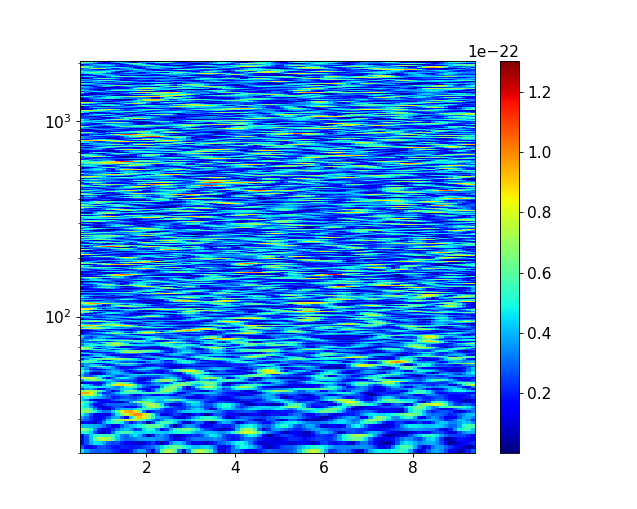

<ipython-input-226-86abc08e66a7>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tp,fp,np.sqrt(Sxxp), cmap='jet')


In [226]:
fp, tp, Sxxp = scipy.signal.spectrogram(h_w[t_s:t_e], fs=fs, window='hamming', nperseg=fs,
    noverlap=fs*9//10)

plt.figure(figsize=(10,8))
plt.pcolormesh(tp,fp,np.sqrt(Sxxp), cmap='jet')
plt.colorbar()
plt.yscale('log')       # logarithmic scaling of the axis
plt.ylim(20,2048);      # choose appropriate interval

# Code for images with continuous wavelet transform (CWT)

A more powerful method to represent the data in the time-frequency domain is to use the wavelet transform. This is the same method used by WDF to decompose the data using wavelets. A python library which carries out the wavelet transform and allows a straightforward visualization is `ssqueezepy`. It also allows to build the synchrosqueezed version of the wavelet decomposition (see documentation). Its usage is shown here, along with a simple plotting function

In [208]:
ssq_cwt??

In [215]:
ssqueezepy.cwt??

<IPython.core.display.Javascript object>


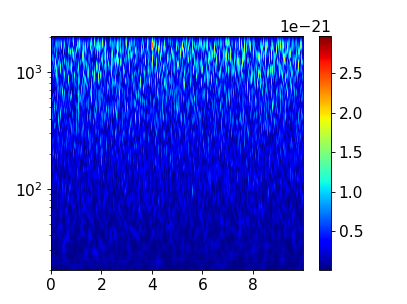

<ipython-input-220-f9f5fc380607>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.arange(0,len(x))/fs,ssq_freqs[::-1],np.abs(Wx), cmap='jet')


<IPython.core.display.Javascript object>


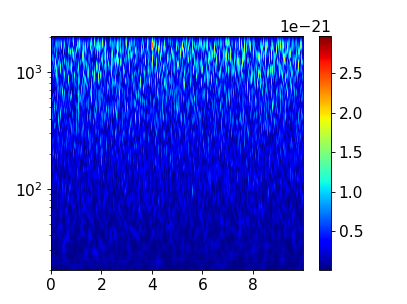

In [220]:
from ssqueezepy import ssq_cwt, ssq_stft, cwt 

def viz(x, Tx, Wx, ssq_freqs):
    fs=4096
  #  plt.imshow(np.abs(Wx), aspect='auto', cmap='jet')
    plt.pcolormesh(np.arange(0,len(x))/fs,ssq_freqs[::-1],np.abs(Wx), cmap='jet')
    plt.yscale('log')
    plt.colorbar();
    plt.ylim(20, max(ssq_freqs))
   # plt.imshow(np.abs(Tx), aspect='auto', cmap='jet')


plt.figure() 

#%%# CWT + SSQ CWT ####################################
Twx, Wx, ssq_freqsx, *_ = ssq_cwt(h_w[t_s:t_e], fs=fs)
W, scales= cwt(h_w[t_s:t_e], fs=fs)
viz(h_w[t_s:t_e], Twx, Wx, ssq_freqsx)

plt.figure()
viz(h_w[t_s:t_e], Twx, W, ssq_freqsx)




In [182]:
ssq_cwt??